# The MAXWEL Model

## Initialization

In [1]:
import pandas as pd
import numpy as np
import dill
from random import sample
from tqdm import tqdm_notebook

from keras.layers import Dense, Lambda ,Input, LSTM, GRU, Dropout, Conv1D, Bidirectional, Flatten, Reshape, Permute, concatenate
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


## Build the Model

In [2]:
def MAXWEL_model(input_shape,
                 num_GRU1=10, num_conv=10,
                 size_conv=6, num_GRU2=10, 
                 num_dense1=10, num_dense2=10,
                 dropout=.15, GRU_dropout=.15,
                 learn_rate=.005, learn_rate_decay=0):
    
    # Setup the input layer
    inp= Input(shape = input_shape)
    
    # Transpose the input data, so that each GRU sees one timestep across all features
    trans=Permute((2,1))(inp)
    
    # The first Bidirectional Gated Recurrent Unit (BiGRU), reads forwards and backwards in time. Note the 
    # return_sequences=True kwarg, this BiGRU will return all of its memory states. The recurrent_dropout
    # kwargs protects from overfitting.
    GRU1 = Bidirectional(GRU(num_GRU1, return_sequences = True, recurrent_dropout=GRU_dropout))(trans)
    
    # A dropout layer
    drop1= Dropout(rate=dropout)(GRU1)
    
    # A 1-D convolutional layer which acts on the memory states of GRU1, intuitively small kernel sizes will perform
    # edge detection on the memory states, i.e. large local changes. This also performs some down-sampling in time.
    conv= Conv1D(num_conv, size_conv, padding="valid")(drop1)
    
    # A second BiGRU, which is now looking for patterns in an abstracted memory state. 
    GRU2= Bidirectional(GRU(num_GRU2, return_sequences=True,recurrent_dropout=GRU_dropout))(conv)
                        
    # A dropout layer
    drop2= Dropout(rate=dropout)(GRU2)
                        
    # Flatten the memory states
    flat=Flatten()(drop2)
    
    # Two dense layers to mediate the prediction process. Note the liner activation function (identity),
    # we use this because our output distribution should be N(0,1). The two layers in concert introduce 
    # some degree of nonlinearity
    dense1=Dense(10,activation="linear")(flat)
    dense2=Dense(5,activation="linear")(dense1)
    
    # The output layer
    out = Dense(4,activation="linear")(dense2)
    
    # Compile the model
    model = Model(inputs = inp, outputs = out)
    model.compile(loss = "mean_squared_error", 
                   optimizer = Adam(lr = learn_rate, decay = learn_rate_decay))
    
    return model  

Build a test model, to check everything.

In [ ]:
test=MAXWEL_model((24,8))
test.summary()

## Train the Models

For each of the 50 stations, we will import the pre-processed data, build data slices, train on most of those slices, and validate the model on the last 10 days performance. 

To validate the model we will use a slightly modified $R^2$ score; as we are predicting 4 hours in the future, we will score each hour we are predicting, i.e. from our true data $Y_{true}=(Y_{true,1} ,\cdots, Y_{true,4})$ and our predicted data $Y_{pred}=(Y_{pred,1},\cdots,Y_{pred,4})$ we compute:

$
R_{col}^2=\left( 1-\frac{\mathbb{E}\left[ (Y_{pred,1}-Y_{true,1})^2 \right]}{\mathbb{E}\left[(Y_{pred,1}-\mathbb{E}[Y_{true,1}])^2 \right]},
1-\frac{\mathbb{E}\left[ (Y_{pred,2}-Y_{true,2})^2 \right]}{\mathbb{E}\left[(Y_{pred,2}-\mathbb{E}[Y_{true,2}])^2 \right]},
1-\frac{\mathbb{E}\left[ (Y_{pred,3}-Y_{true,3})^2 \right]}{\mathbb{E}\left[(Y_{pred,3}-\mathbb{E}[Y_{true,3}])^2 \right]},
1-\frac{\mathbb{E}\left[ (Y_{pred,4}-Y_{true,4})^2 \right]}{\mathbb{E}\left[(Y_{pred,4}-\mathbb{E}[Y_{true,4}])^2 \right]}\right)
$

and we call this the columnar $R^2$ score. Note this will be a useful gauge out how prediction accuracy changes over time.


In [3]:
def columnar_R2(mat_predict,mat_true):
    top=mat_predict.shape[1]
    out=np.zeros(top)
    for i in range(top):
        out[i]=1-np.linalg.norm(mat_predict[:,i]-mat_true[:,i])/np.linalg.norm(mat_predict[:,i]-mat_true[:,i].mean())
    return out

Next we define our make_slices method:

In [4]:
def make_slices(name,num_valid=300):
    
    # Load in the preprocessed dataframe:
    df_in=pd.read_csv(f"Data/MAXWEL_Data/{name}.csv")
    df_in=df_in.drop(columns=['time']).interpolate()
    
    # We build a dictionary that contains the important data for 
    # this station
    data_info={}
    data_info['primary']=name
    
    # Note the num_features will change depending on the number
    # of interchanges for this station, which will need to be fed
    # to the model!
    data_info['num_features']=df_in.shape[1]
    data_info['num_samples']=df_in.shape[0]
 
    # Build a tensor of 24,4 hour slices, which are co-indexed
    X=np.zeros((df_in.shape[0], 24, df_in.shape[1]))
    Y=np.zeros((df_in.shape[0], 4))
    
    # This indexing avoids drawing data which doesn't have 
    # 4 hours of data after it
    for i in range(df_in.shape[0]-(24+4+1)):
        X[i,:,:]=df_in.iloc[i:i+24].values
        Y[i,:]=np.asarray(df_in[f'{name}_scaled_demand'][i+24:i+24+4].values)
    
    # Now we split off the validation data
    data_info['num_valid_samples']=num_valid
    
    num_train=df_in.shape[0]-num_valid
    
    # Build the training, validation tensors
    X_train=np.zeros((num_train, 24, df_in.shape[1]))
    Y_train=np.zeros((num_train, 4))
    
    X_valid=np.zeros((num_valid, 24, df_in.shape[1]))
    Y_valid=np.zeros((num_valid, 4))

    for i in range(num_train-29):
        X_train[i,:,:]=X[i,:,:]
        Y_train[i,:]=Y[i,:]
    for i in range(num_valid):
        X_valid[i,:,:]=X[i+num_train-29,:,:]
        Y_valid[i,:]=Y[i+num_train-29,:]
        
    return X_train, Y_train, X_valid, Y_valid, data_info

Now we loop over each station: make the slices, train a model, compute its validation score, and save the results.

N.B. This fits all 50 models, so it can take up to 3 hours to run.

In [ ]:
MAXWEL_models={}
station_metadata_df=pd.read_csv("Data/Metadata/station_meta_data.csv")
names=station_metadata_df['station_tag'].unique()

for name in tqdm_notebook(names):
    
    # Make the training data
    X_train, Y_train, X_valid, Y_valid, data_info=make_slices(name)
    
    # Record the data info
    MAXWEL_models[name]={}
    MAXWEL_models[name]['data_info']=data_info
    
    # Initialize a model
    model=MAXWEL_model((24,data_info['num_features']))
    
    # Fit the model
    history=model.fit(X_train,Y_train,
                      batch_size=8,
                      epochs=10,
                      verbose=0,
                      validation_data=(X_valid,Y_valid))
    
    # Save the model and the fit data
    MAXWEL_models[name]['model']=model
    MAXWEL_models[name]['history']=history
    
    # Compute and record the R^2_col score
    Y_predict=model.predict(X_valid)
    MAXWEL_models[name]['R2_score']=columnar_R2(Y_predict,Y_valid)

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [6]:
MAXWEL_models

{'CPLW': {'data_info': {'primary': 'CPLW',
   'num_features': 10,
   'num_samples': 12690,
   'num_valid_samples': 300},
  'model': <keras.engine.training.Model at 0x7ff7c2cc0198>,
  'history': <keras.callbacks.History at 0x7ff7c2cf14a8>,
  'R2_score': array([0.7794636 , 0.71523399, 0.65781013, 0.58607598])},
 'NYIS': {'data_info': {'primary': 'NYIS',
   'num_features': 9,
   'num_samples': 12690,
   'num_valid_samples': 300},
  'model': <keras.engine.training.Model at 0x7ff7c1e232e8>,
  'history': <keras.callbacks.History at 0x7ff7c1e3c7b8>,
  'R2_score': array([0.83003937, 0.80449747, 0.78582943, 0.76531245])},
 'GCPD': {'data_info': {'primary': 'GCPD',
   'num_features': 11,
   'num_samples': 12690,
   'num_valid_samples': 300},
  'model': <keras.engine.training.Model at 0x7ff75c0a94e0>,
  'history': <keras.callbacks.History at 0x7ff75c16e400>,
  'R2_score': array([0.71254972, 0.67542263, 0.70411915, 0.69364315])},
 'LGEE': {'data_info': {'primary': 'LGEE',
   'num_features': 10,
  

In [ ]:
MAXWEL_R2_scores={}
for key in MAXWEL_models:
    MAXWEL_R2_scores[key]=MAXWEL_models[key]['R2_score']

MAXWEL_R2_df=pd.DataFrame(MAXWEL_R2_scores).T
MAXWEL_R2_df['mean']=MAXWEL_R2_df.mean(axis=1)
MAXWEL_R2_df=MAXWEL_R2_df.sort_values('mean')

MAXWEL_R2_df.to_csv('Saved_Models/Results/MAXWEL_R2.csv')

## Model Comparison

Here we compare the 4-hour $R^2$ values of the MAXWEL model with the EIA day-ahead model.

In [27]:
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144
import matplotlib.pyplot as plt

MAXWEL_R2=pd.read_csv('Saved_Models/Results/MAXWEL_R2.csv').set_index('Unnamed: 0')
DA_R2=pd.read_csv('Saved_Models/Results/day_ahead_R2.csv').set_index('Unnamed: 0')

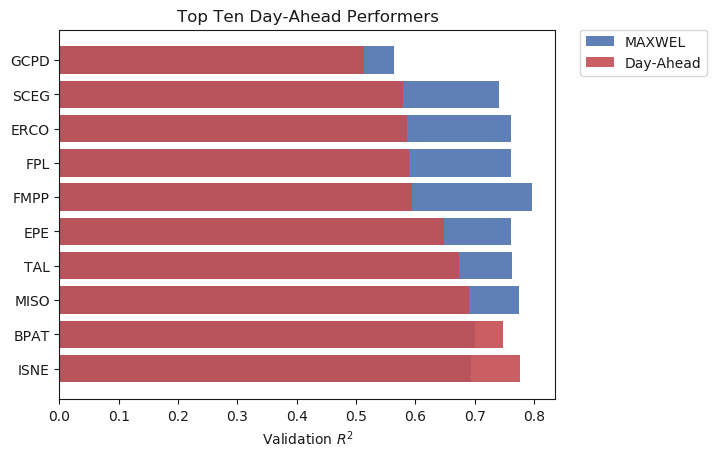

In [28]:
num=10
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
stations = list(DA_R2[-num:].index)
y_pos = np.arange(len(stations))

performance = DA_R2['mean'][-num:]
performance2 = MAXWEL_R2.loc[list(DA_R2[-num:].index)]['mean']

ax.barh(y_pos, performance2, color='b',alpha=.9, align='center',label="MAXWEL")
ax.barh(y_pos, performance, color='r',alpha=.9, align='center',label="Day-Ahead")
ax.set_yticks(y_pos)
ax.set_yticklabels(stations)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Validation $R^2$')
ax.set_title('Top Ten Day-Ahead Performers')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig

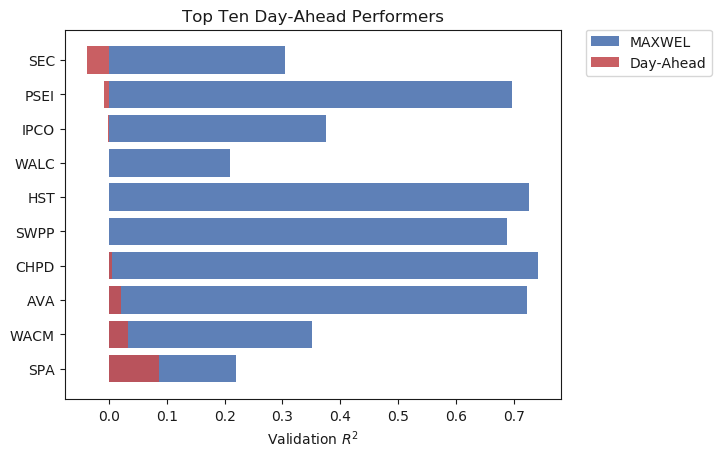

In [30]:
num=10
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
stations = list(DA_R2[:num].index)
y_pos = np.arange(len(stations))

performance = DA_R2['mean'][:num]
performance2 = MAXWEL_R2.loc[list(DA_R2[:num].index)]['mean']

ax.barh(y_pos, performance2, color='b',alpha=.9, align='center',label="MAXWEL")
ax.barh(y_pos, performance, color='r',alpha=.9, align='center',label="Day-Ahead")
ax.set_yticks(y_pos)
ax.set_yticklabels(stations)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Validation $R^2$')
ax.set_title('Bottom Ten Day-Ahead Performers')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig

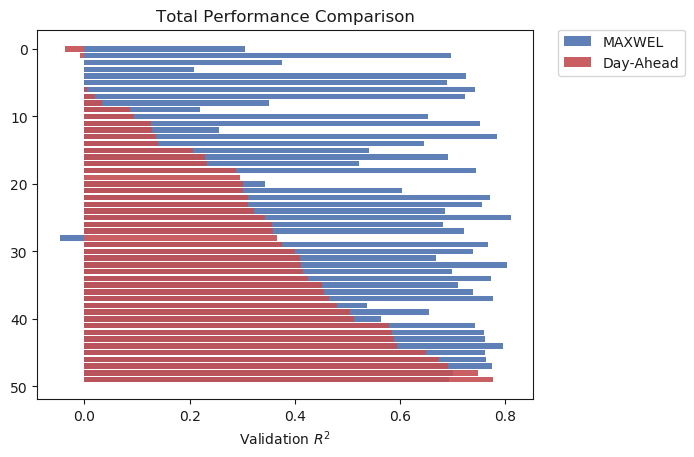

In [34]:
num=50
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
stations = list(DA_R2[:num].index)
y_pos = np.arange(len(stations))

performance = DA_R2['mean'][:num]
performance2 = MAXWEL_R2.loc[list(DA_R2[:num].index)]['mean']

ax.barh(y_pos, performance2, color='b',alpha=.9, align='center',label="MAXWEL")
ax.barh(y_pos, performance, color='r',alpha=.9, align='center',label="Day-Ahead")

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Validation $R^2$')
ax.set_title('Total Performance Comparison')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig

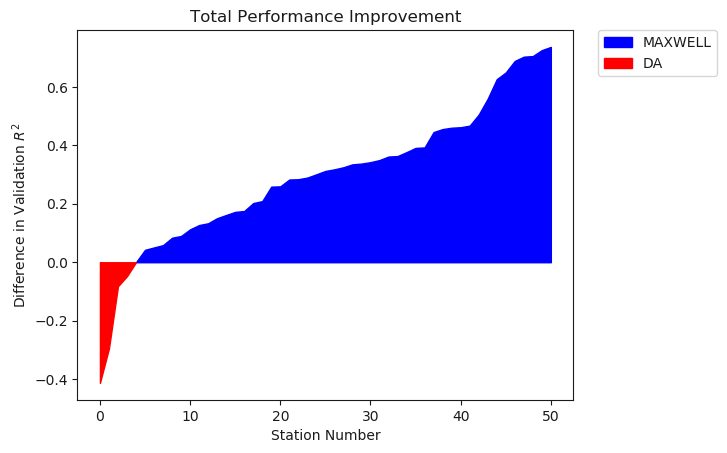

In [39]:
sort=np.asarray((MAXWEL_R2-DA_R2).sort_values('mean').index)
split=4
plot1=list((MAXWEL_R2.loc[sort]['mean'][split:]-DA_R2.loc[sort]['mean'][split:]).values)
plot1.insert(0,0)
plot2=list(MAXWEL_R2.loc[sort]['mean'][:split]-DA_R2.loc[sort]['mean'][:split].values)
plot2.append(0)

split=4
fig, ax = plt.subplots()
ax.fill_between(range(split,len(sort)+1),plot1,color='blue',label='MAXWELL')
ax.fill_between(range(split+1),plot2,color='red',label='DA')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Station Number')
ax.set_ylabel('Difference in Validation $R^2$')
ax.set_title("Total Performance Improvement")

fig